# Příběh
První den jsme naměřili 3 signály s neporušenými frekvencemi, ve kterých pár chybělo. Další 4 dny jsme měřili opět tři signály denně s tím, že dva dny byly frekvence neporušené a další dva dny porušené (posunuté o pár Hz náhodným směrem). Opět v některých datech nebyly některé frekvence vybuzeny. Naším cílem je pomocí dat z prvního dne rozeznat neporušená data od porušených. Klíčem k tomu je průměrování denních dat (čímž se odstraní problém s nevybuzenými frekvencemi) a multiškálová binarizace (která zajišťuje, že i přes různou míru vybuzení jsou všechny přirozené frekvence detekovány).

# Postup
 1. vygenerovat 3 signály s 3mi natural frekvencemi (+noise)
    1. v jedné chybí jedna vybuzená frekvence, v druhé dvě vybuzené frekvence, v třetí jsou všechny
    1. vykreslit a uložit
 2. vygenerovat další 3 signály za den s 3mi natural frekvencemi (+noise)
    1. dejme tomu že vygenerujeme dva dny s neporušenými frekvencemi
    1. a dva dny s porušennými frekvencemi (mírně posunuté)
 3. porovnat PSD signálů (ze samotných se nic nepozná, protože některé vl. frekvence chybí) 
 4. agregovat do průměrných denních hodnot PSD signálů (v těch už jsou všechny vl. frekvence)

# Generate Data

1. DONE: uložit grafy jednotlivých vygenerovaných signálů
1. DONE: upravit Generator, abychom mohli potlačit vybuzení některých přirozených frekvencí

In [1]:
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from bin.flags import FLAGS
from bin.helpers import console_logger, plotter
from bin.Generator import Generator
from bin.Preprocessor import Preprocessor

In [2]:
def generate_and_compute_snr(signal_gen, noise_gen, shape=(10, 15360), omit=tuple()):
    assert len(shape) == 2, "given shape must be shape 2 Tuple or List"
    signal = signal_gen.generate(*shape, omit)
    noise = noise_gen.generate(*shape)

    SS = np.abs(np.fft.fft(signal))**2
    NN = np.abs(np.fft.fft(noise))**2
    PSNR_dB = 10*np.log(np.max(SS)/np.mean(NN))  # dB Signal to noise ratio

    LOGGER.debug(f"PSNR_dB: {PSNR_dB:.3f} dB")
    return signal + noise, PSNR_dB

   INFO (__main__) 2020-09-16 14:22:53 - Initialising signal and noise generators.
   INFO (__main__) 2020-09-16 14:22:53 - Generating signal values with added noise.
   INFO (__main__) 2020-09-16 14:22:55 - Splitting unshifted and shifted signal values to groups of 3.
   INFO (__main__) 2020-09-16 14:22:55 - Zeroing out certain natural frequencies.
   INFO (__main__) 2020-09-16 14:22:55 - Concatenating unbroken and broken test data
   INFO (__main__) 2020-09-16 14:22:55 - Preprocessing signals to psd using Preprocessor with default values.
   INFO (__main__) 2020-09-16 14:22:55 - Reshaping to M2 compatible shape.
   INFO (__main__) 2020-09-16 14:22:55 - Generating save file names.
   INFO (__main__) 2020-09-16 14:22:55 - Saving raw signals to files.
   INFO (__main__) 2020-09-16 14:22:55 - Saving generated arrays to files.
   INFO (__main__) 2020-09-16 14:22:55 - Plotting results.
   INFO (__main__) 2020-09-16 14:22:55 - Plotting noisy signals.
   INFO (__main__) 2020-09-16 14:22:55 -

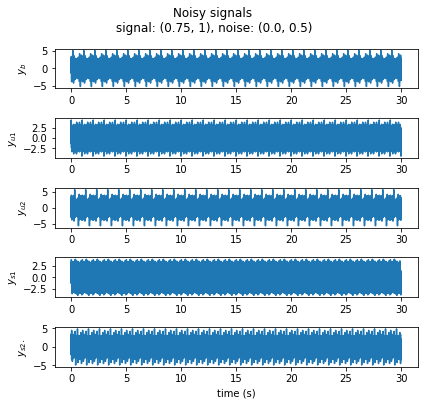

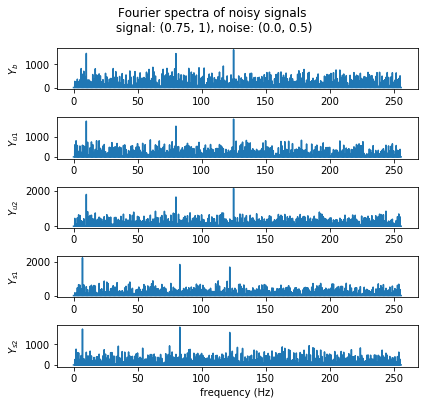

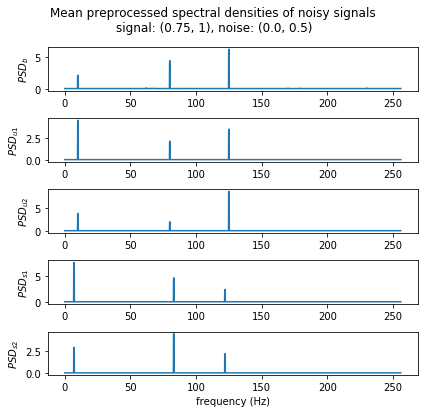

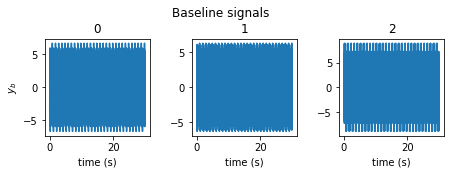

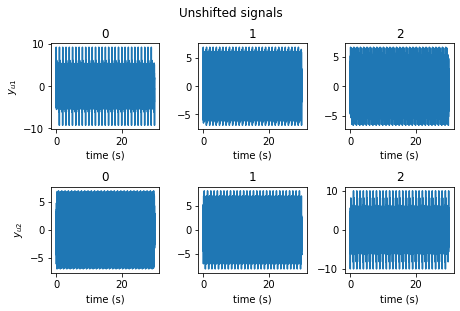

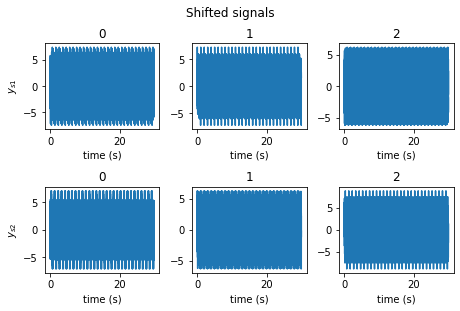

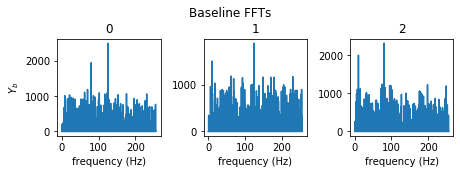

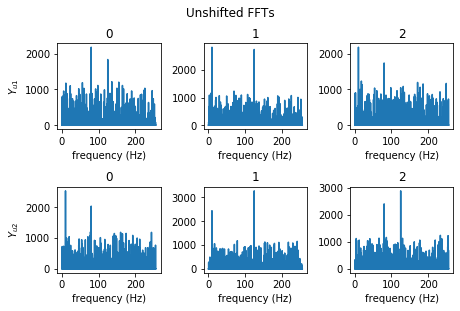

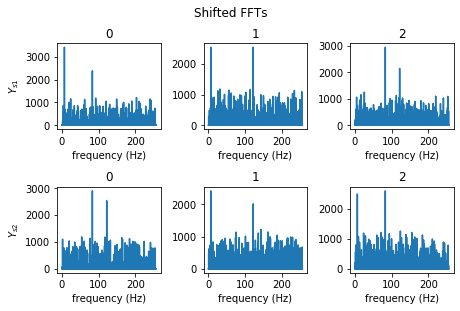

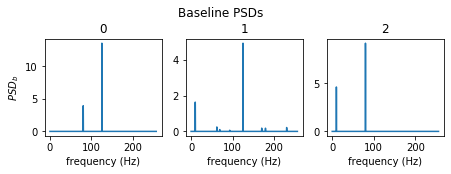

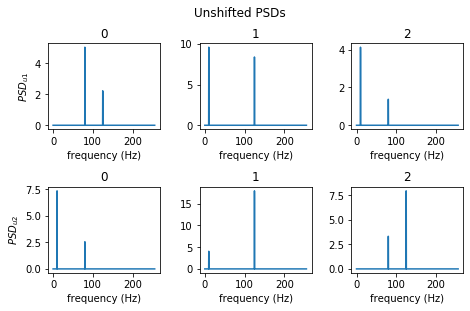

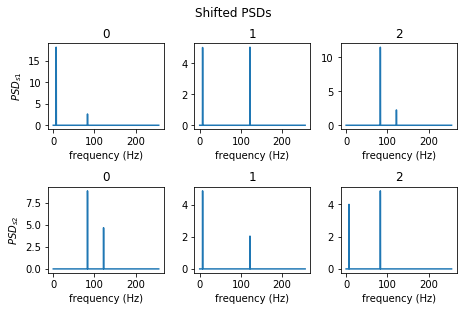

In [10]:
LOGGER = console_logger(__name__, "INFO")
PSNR_CSV_SETUP = FLAGS.PSNR_csv_setup

if __name__ == '__main__':
    nrepeats = 1
    signal_amps = [(0.75, 1)]
    noise_amps = [(0., 0.5)]
    noise_category_names = ["noise"]

    fs = 512
    nfft = 5120
    nsamples = 15360
    root = "./data/for_article/generated"
    plot_exts = [".pdf", ".svg"]

    dPSNR = {"episode": [], "signal_amp_max": [], "noise_amp_max": [], "train_PSNR (dB)": [], "test_PSNR (dB)": []}

    plot_divided = True

    for i in range(nrepeats):
        for s_amp in signal_amps:
            for n_amp, n_name in zip(noise_amps, noise_category_names):
                dtrain = {"nsig": 3, "fvs": (10., 80., 125.), "amp_range": s_amp,
                          "shift_range": (0, 0), "path": f"{root}/{n_name}/train/", "omit": (0, 1, 2)}
                dtest = {"nsig": 6, "fvs": (10., 80., 125.), "amp_range": s_amp,
                         "shift_range": (0, 0), "path": f"{root}/{n_name}/test/", "omit": (0, 1, 2, 2, 1, 0)}
                dtest_br = {"nsig": 6, "fvs": (7., 83., 122.), "amp_range": s_amp,
                            "shift_range": (0, 0), "path": f"{root}/{n_name}/test/", "omit": (2, 1, 0, 0, 1, 2)}
                dnoise = {"fvs": np.arange(fs), "amp_range": n_amp, "shift_range": (0, 0)}

                LOGGER.info("Initialising signal and noise generators.")
                g_train = Generator(fs, fvs=dtrain["fvs"], amp_range=dtrain["amp_range"],
                                    shift_range=dtrain["shift_range"])
                g_test = Generator(fs, fvs=dtest["fvs"], amp_range=dtest["amp_range"], shift_range=dtest["shift_range"])
                g_test_br = Generator(fs, fvs=dtest_br["fvs"], amp_range=dtest_br["amp_range"],
                                      shift_range=dtest_br["shift_range"])
                g_noise = Generator(fs, fvs=dnoise["fvs"], amp_range=dnoise["amp_range"],
                                    shift_range=dnoise["shift_range"])

                LOGGER.info("Generating signal values with added noise.")
                t = np.arange(nsamples) / fs
                x_train, PSNR_train = generate_and_compute_snr(g_train, g_noise,
                                                               shape=(dtrain["nsig"], nsamples),
                                                               omit=dtrain["omit"])
                x_test_un, PSNR_test_un = generate_and_compute_snr(g_test, g_noise,
                                                                   shape=(dtest["nsig"], nsamples),
                                                                   omit=dtest["omit"])
                x_test_br, PSNR_test_br = generate_and_compute_snr(g_test_br, g_noise,
                                                                   shape=(dtest_br["nsig"], nsamples),
                                                                   omit=dtest_br["omit"])
                LOGGER.debug(f"x_train.shape: {x_train.shape}, "
                             f"x_test_un.shape: {x_test_un.shape}, "
                             f"x_test_br.shape: {x_test_br.shape}")

                LOGGER.info("Splitting unshifted and shifted signal values to groups of 3.")
                x_test_un_1 = x_test_un[0:3, :]
                x_test_un_2 = x_test_un[3:, :]
                x_test_br_1 = x_test_br[0:3, :]
                x_test_br_2 = x_test_br[3:, :]

                LOGGER.info("Zeroing out certain natural frequencies.")
#                x_train = zero_out_freqs_pattern(x_train, fs, freqs=(dtrain["fvs"]))
#                x_test_un = zero_out_freqs_pattern(x_test_un, fs, freqs=(dtest["fvs"]))
#                x_test_br = zero_out_freqs_pattern(x_test_br, fs, freqs=(dtest_br["fvs"]))
                LOGGER.debug(f"x_train.shape: {x_train.shape}, "
                             f"x_test_un.shape: {x_test_un.shape}, "
                             f"x_test_br.shape: {x_test_br.shape}")


                LOGGER.info("Concatenating unbroken and broken test data")
                x_test = np.vstack([x_test_un, x_test_br])

                LOGGER.info("Preprocessing signals to psd using Preprocessor with default values.")
                p = Preprocessor()
                freq_train, psd_train = p.simple_preprocess(x_train.T)
                freq_test, psd_test = p.simple_preprocess(x_test.T)
                freq_test_un, psd_test_un = p.simple_preprocess(x_test_un.T)
                freq_test_br, psd_test_br = p.simple_preprocess(x_test_br.T)
                LOGGER.debug(f"psd_train.shape: {psd_train.shape}, psd_test.shape: {psd_test.shape}")
                LOGGER.debug(f"psd_test_un.shape: {psd_test_un.shape}, psd_test_br.shape: {psd_test_br.shape}")

                LOGGER.info("Reshaping to M2 compatible shape.")
                psd_train = np.expand_dims(psd_train.T, axis=-1)
                psd_test = np.expand_dims(psd_test.T, axis=-1)
                psd_test_un = np.expand_dims(psd_test_un.T, axis=-1)
                psd_test_br = np.expand_dims(psd_test_br.T, axis=-1)
                LOGGER.debug(f"psd_train.shape: {psd_train.shape}, psd_test.shape: {psd_test.shape}")

                psd_test_un_1 = psd_test_un[0:3, :, :]
                psd_test_un_2 = psd_test_un[3:, :, :]
                psd_test_br_1 = psd_test_br[0:3, :, :]
                psd_test_br_2 = psd_test_br[3:, :, :]

                LOGGER.debug("Making folder if it doesn't exist")
                os.makedirs(dtrain["path"], exist_ok=True)
                os.makedirs(dtest["path"], exist_ok=True)

                LOGGER.info("Generating save file names.")
                save_name_raw = f"raw{i}_sAmp{s_amp}_nAmp{n_amp}.npy"
                save_name_psd = f"X{i}_sAmp{s_amp}_nAmp{n_amp}.npy"
                freqs_name = f"freqs{i}.npy"

                LOGGER.info("Saving raw signals to files.")
                np.save(os.path.join(dtrain["path"], save_name_raw), x_train)
                LOGGER.debug(f"x_train saved to {dtrain['path']} with file name {save_name_raw}")
                np.save(os.path.join(dtest["path"], save_name_raw), x_test)
                LOGGER.debug(f"x_test saved to {dtest['path']} with file name {save_name_raw}")

                LOGGER.info("Saving generated arrays to files.")
                np.save(os.path.join(dtrain["path"], "freqs.npy"), freq_train)
                LOGGER.debug(f"freq_train saved to {dtrain['path']} with file name {freqs_name}")
                np.save(os.path.join(dtrain["path"], save_name_psd), psd_train)
                LOGGER.debug(f"psd_train saved to {dtrain['path']} with file name {save_name_psd}")
                np.save(os.path.join(dtest["path"], "freqs.npy"), freq_test)
                LOGGER.debug(f"freq_test saved to {dtest['path']} with file name {freqs_name}")
                np.save(os.path.join(dtest["path"], save_name_psd), psd_test)
                LOGGER.debug(f"psd_test saved to {dtest['path']} with file name {save_name_psd}")

                # Vykreslení výsledků
                LOGGER.info("Plotting results.")
                fig, ax = plt.subplots(5, 1)
                fig.set_size_inches(6, 6)
                LOGGER.info("Plotting noisy signals.")
                plt.suptitle("Noisy signals"
                             f"\n signal: {s_amp}, noise: {n_amp}")
                plotter(t, x_train.mean(0), ax[0], title="", ylabel="$y_b$")
                plotter(t, x_test_un_1.mean(0), ax[1], title="", ylabel="$y_{u1}$")
                plotter(t, x_test_un_2.mean(0), ax[2], title="", ylabel="$y_{u2}$")
                plotter(t, x_test_br_1.mean(0), ax[3], title="", xlabel="", ylabel="$y_{s1}$")
                plotter(t, x_test_br_2.mean(0), ax[4], title="", xlabel="time (s)", ylabel="$y_{s2}$.")
                plt.tight_layout(rect=[0, 0.05, 1, 0.91])
                LOGGER.info("Saving noisy signals plot.")
                for ext in plot_exts:
                    save_name = f"xn{i}_sAmp{s_amp}_nAmp{n_amp}{ext}"
                    plt.savefig(os.path.join(root, n_name, save_name))

                # FFT zašumělých signálů
                fss = np.arange(nfft // 2) / nfft * fs
                X_train = abs(np.fft.fft(x_train, nfft))[:, :nfft // 2]
                X_test_un = abs(np.fft.fft(x_test_un, nfft))[:, :nfft // 2]
                X_test_br = abs(np.fft.fft(x_test_br, nfft))[:, :nfft // 2]

                X_test_un_1 = X_test_un[0:3, :]
                X_test_un_2 = X_test_un[3:, :]
                X_test_br_1 = X_test_br[0:3, :]
                X_test_br_2 = X_test_br[3:, :]

                LOGGER.info("Plotting fft of noisy signals")
                fig, ax = plt.subplots(5, 1)
                fig.set_size_inches(6, 6)
                plt.suptitle("Fourier spectra of noisy signals"
                             f"\n signal: {s_amp}, noise: {n_amp}")
                plotter(freq_train, X_train.mean(0), ax[0], ylabel="$Y_{b}$")
                plotter(freq_test_un, X_test_un_1.mean(0), ax[1], ylabel="$Y_{u1}$")
                plotter(freq_test_un, X_test_un_2.mean(0), ax[2], ylabel="$Y_{u2}$")
                plotter(freq_test_br, X_test_br_1.mean(0), ax[3], xlabel="", ylabel="$Y_{s1}$")
                plotter(freq_test_br, X_test_br_2.mean(0), ax[4], xlabel="frequency (Hz)", ylabel="$Y_{s2}$")
                plt.tight_layout(rect=[0, 0.05, 1, 0.91])
                LOGGER.info("Saving fft of noisy signals plot.")
                for ext in plot_exts:
                    save_name = f"fft{i}_sAmp{s_amp}_nAmp{n_amp}{ext}"
                    plt.savefig(os.path.join(root, n_name, save_name))

                # Preprocessing zašumělých signálů a jejich průměr
                LOGGER.info("Plotting mean preprocessed spectral densities of noisy signals")
                fig, ax = plt.subplots(5, 1)
                fig.set_size_inches(6, 6)
                plt.suptitle("Mean preprocessed spectral densities of noisy signals"
                             f"\n signal: {s_amp}, noise: {n_amp}")
                plotter(freq_train, psd_train.mean(axis=(0, -1)), ax[0], ylabel="$PSD_b$")
                plotter(freq_test_un, psd_test_un_1.mean(axis=(0, -1)), ax[1], ylabel="$PSD_{u1}$")
                plotter(freq_test_un, psd_test_un_2.mean(axis=(0, -1)), ax[2], ylabel="$PSD_{u2}$")
                plotter(freq_test_br, psd_test_br_1.mean(axis=(0, -1)), ax[3], ylabel="$PSD_{s1}$")
                plotter(freq_test_br, psd_test_br_2.mean(axis=(0, -1)), ax[4], xlabel="frequency (Hz)",
                        ylabel="$PSD_{s2}$")
                plt.tight_layout(rect=[0, 0.03, 1, 0.91])
                LOGGER.info("Saving mean preprocessed spectral densities of noisy signals plot.")
                for ext in plot_exts:
                    save_name = f"PSD{i}_sAmp{s_amp}_nAmp{n_amp}{ext}"
                    plt.savefig(os.path.join(root, n_name, save_name))

                # Vykreslení a uložení grafů jednotlivých signálů
                if plot_divided:
                    LOGGER.info("Plotting divided signals.")
                    LOGGER.info("\t Creating subdirectories")
                    subdirs = (f"{root}/{n_name}/divided/raw/training",
                               f"{root}/{n_name}/divided/raw/test_unshifted",
                               f"{root}/{n_name}/divided/raw/test_shifted")
                    os.makedirs(subdirs[0], exist_ok=True)
                    os.makedirs(subdirs[1], exist_ok=True)
                    os.makedirs(subdirs[2], exist_ok=True)
                    LOGGER.info("\t Training signals")
                    fig, ax = plt.subplots(1, 3)
                    fig.set_size_inches(6.5, 2.5)
                    for j in range(3):
                        plotter(t, x_train[j, :], ax[j], title=f"{j%3}", xlabel="time (s)")
                    plt.suptitle("Baseline signals")
                    ax[0].set_ylabel("$y_b$")
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    for ext in plot_exts:
                        plt.savefig(f"{subdirs[0]}/xn{i}_sAmp{s_amp}_nAmp{n_amp}{ext}")

                    LOGGER.info("\t Unshifted test signals")
                    fig, ax = plt.subplots(2, 3)
                    fig.set_size_inches(6.5, 4.5)
                    ax = ax.flatten()
                    for j in range(6):
                        plotter(t, x_test_un[j, :], ax[j], title=f"{j%3}", xlabel="time (s)")
                    plt.suptitle("Unshifted signals")
                    ax[0].set_ylabel("$y_{u1}$")
                    ax[3].set_ylabel("$y_{u2}$")
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    for ext in plot_exts:
                        plt.savefig(f"{subdirs[1]}/xn{i}_sAmp{s_amp}_nAmp{n_amp}{ext}")

                    LOGGER.info("\t Shifted test signals")
                    fig, ax = plt.subplots(2, 3)
                    fig.set_size_inches(6.5, 4.5)
                    ax = ax.flatten()
                    for j in range(6):
                        plotter(t, x_test_br[j, :], ax[j], title=f"{j%3}", xlabel="time (s)")
                    plt.suptitle("Shifted signals")
                    ax[0].set_ylabel("$y_{s1}$")
                    ax[3].set_ylabel("$y_{s2}$")
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    for ext in plot_exts:
                        plt.savefig(f"{subdirs[2]}/xn{i}_sAmp{s_amp}_nAmp{n_amp}{ext}")

                    LOGGER.info("Plotting divided FFTs.")
                    LOGGER.info("\t Creating subdirectories")
                    subdirs = (f"{root}/{n_name}/divided/fft/training",
                               f"{root}/{n_name}/divided/fft/test_unshifted",
                               f"{root}/{n_name}/divided/fft/test_shifted")
                    os.makedirs(subdirs[0], exist_ok=True)
                    os.makedirs(subdirs[1], exist_ok=True)
                    os.makedirs(subdirs[2], exist_ok=True)
                    LOGGER.info("\t Training FFTs")
                    fig, ax = plt.subplots(1, 3)
                    fig.set_size_inches(6.5, 2.5)
                    for j in range(3):
                        plotter(freq_train, X_train[j, :], ax[j], title=f"{j%3}", xlabel="frequency (Hz)")
                    plt.suptitle("Baseline FFTs")
                    ax[0].set_ylabel("$Y_b$")
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    for ext in plot_exts:
                        plt.savefig(f"{subdirs[0]}/fft{i}_sAmp{s_amp}_nAmp{n_amp}{ext}")

                    LOGGER.info("\t Unshifted test FFTs")
                    fig, ax = plt.subplots(2, 3)
                    fig.set_size_inches(6.5, 4.5)
                    ax = ax.flatten()
                    for j in range(6):
                        plotter(freq_test_un, X_test_un[j, :], ax[j], title=f"{j%3}", xlabel="frequency (Hz)")
                    plt.suptitle("Unshifted FFTs")
                    ax[0].set_ylabel("$Y_{u1}$")
                    ax[3].set_ylabel("$Y_{u2}$")
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    for ext in plot_exts:
                        plt.savefig(f"{subdirs[1]}/fft{i}_sAmp{s_amp}_nAmp{n_amp}{ext}")

                    LOGGER.info("\t Shifted test FFTs")
                    fig, ax = plt.subplots(2, 3)
                    fig.set_size_inches(6.5, 4.5)
                    ax = ax.flatten()
                    for j in range(6):
                        plotter(freq_test_br, X_test_br[j, :], ax[j], title=f"{j%3}", xlabel="frequency (Hz)")
                    plt.suptitle("Shifted FFTs")
                    ax[0].set_ylabel("$Y_{s1}$")
                    ax[3].set_ylabel("$Y_{s2}$")
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    for ext in plot_exts:
                        plt.savefig(f"{subdirs[2]}/fft{i}_sAmp{s_amp}_nAmp{n_amp}{ext}")

                    LOGGER.info("Plotting divided PSDs.")
                    LOGGER.info("\t Creating subdirectories")
                    subdirs = (f"{root}/{n_name}/divided/psd/training",
                               f"{root}/{n_name}/divided/psd/test_unshifted",
                               f"{root}/{n_name}/divided/psd/test_shifted")
                    os.makedirs(subdirs[0], exist_ok=True)
                    os.makedirs(subdirs[1], exist_ok=True)
                    os.makedirs(subdirs[2], exist_ok=True)
                    LOGGER.info("\t Training PSDs")
                    fig, ax = plt.subplots(1, 3)
                    fig.set_size_inches(6.5, 2.5)
                    for j in range(3):
                        plotter(freq_train, psd_train[j, :], ax[j], title=f"{j%3}", xlabel="frequency (Hz)")
                    plt.suptitle("Baseline PSDs")
                    ax[0].set_ylabel("$PSD_b$")
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    for ext in plot_exts:
                        plt.savefig(f"{subdirs[0]}/PSD{i}_sAmp{s_amp}_nAmp{n_amp}{ext}")

                    LOGGER.info("\t Unshifted test PSDs")
                    fig, ax = plt.subplots(2, 3)
                    fig.set_size_inches(6.5, 4.5)
                    ax = ax.flatten()
                    for j in range(6):
                        plotter(freq_test_un, psd_test_un[j, :], ax[j], title=f"{j%3}", xlabel="frequency (Hz)")
                    plt.suptitle("Unshifted PSDs")
                    ax[0].set_ylabel("$PSD_{u1}$")
                    ax[3].set_ylabel("$PSD_{u2}$")
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    for ext in plot_exts:
                        plt.savefig(f"{subdirs[1]}/PSD{i}_sAmp{s_amp}_nAmp{n_amp}{ext}")

                    LOGGER.info("\t Shifted test PSDs")
                    fig, ax = plt.subplots(2, 3)
                    fig.set_size_inches(6.5, 4.5)
                    ax = ax.flatten()
                    for j in range(6):
                        plotter(freq_test_br, psd_test_br[j, :], ax[j], title=f"{j%3}", xlabel="frequency (Hz)")
                    plt.suptitle("Shifted PSDs")
                    ax[0].set_ylabel("$PSD_{s1}$")
                    ax[3].set_ylabel("$PSD_{s2}$")
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    for ext in plot_exts:
                        plt.savefig(f"{subdirs[2]}/PSD{i}_sAmp{s_amp}_nAmp{n_amp}{ext}")


                # Uložení PSNR do slovníku
                # {"i": [], "signal_amp": [], "noise_amp": [], "train_PSNR (dB)": [], "test_PSNR (dB)": []}
                LOGGER.info("Saving PSNR values to dictionary")
                dPSNR["episode"].append(i)
                dPSNR["signal_amp_max"].append(s_amp[1])
                dPSNR["noise_amp_max"].append(n_amp[1])
                dPSNR["train_PSNR (dB)"].append(PSNR_train)
                dPSNR["test_PSNR (dB)"].append(np.mean([PSNR_test_un, PSNR_test_br]))
                LOGGER.debug(f"dPSNR.values: {list(dPSNR.values())}")
    dfPSNR = pd.DataFrame(dPSNR, columns=list(dPSNR.keys()))
    with open(os.path.join(root, PSNR_CSV_SETUP["name"]), "w") as f:
        dfPSNR.to_csv(f, sep=PSNR_CSV_SETUP["sep"], decimal=PSNR_CSV_SETUP["decimal"], index=PSNR_CSV_SETUP["index"],
                      columns=PSNR_CSV_SETUP["columns"], line_terminator=PSNR_CSV_SETUP["line_terminator"])

    plt.show()